# Gabor Filters

Now that we've played around a bit with what the neural network thinks are good filters for ResNet50, can our own biological neural network come up with a set of 64 **better** filters? Probably not!

Gabor filters are linear filters used for edge detection and texture analysis. We're hoping that we can manually create some filters and use them as the first layer of our neural network.

## Creating a Gabor Filter

A gabor filter can be created via this function: ![](https://i.imgur.com/3u8H6VF.png)

Here is what they tell me these letters mean:
 - **x** The width of the desired filter
 - **y** The height of the desired filter
 - **σ** The standard deviation of the Gaussian function. Increasing it causes more lines in the filter.
 - **Θ** The filter orientation/rotation
 - **λ** The wavelength of the sinusoidal factor
 - **γ** The spatial aspect factor (???)
 - **ψ** The phase offset
 
 


I'm following [this paper]() which used these settings for those letters:

![image.png](https://i.imgur.com/qUeWLUG.png)

They created `5x5` filters, so we'll do the same to sanity check that we're not messing everything up.

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from lucent.optvis import render
from fastai.vision.models import resnet50

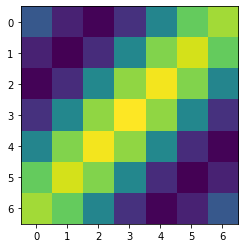

In [2]:
ksize = (7, 7)
sigma = 3
theta = 1 * np.pi / 4
lambd = 8 * np.pi / 4
gamma = 0.5
phi = 0

result = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi=0,  ktype=cv2.CV_32F)
plt.imshow(result)

## Creating a filter bank

We have to create 64 kernels. My plan is to have:
 - 16 Black and White kernels
 - 16 Red and Green kernels
 - 16 Red and Blue kernels
 - 16 Green and Blue Kernels

For a set of 16 kernels we will have:
 - 8 light to dark
 - 8 dark to light
 
For a set of 8 kernels we will have:


In [3]:
def generate_filter_bank():
    """ 
    Generates 16 Gabor filters by varying theta (rotation) and lambda (wavelength)
    """

    ksize = (7, 7)
    sigma = 3
    gamma = 0.75
    phi = 0
    
    lambd_1 = 1 * np.pi / 4
    lambd_2 = 4 * np.pi / 4
    
    theta_1 = 1 * np.pi / 4
    theta_2 = 2 * np.pi / 4
    theta_3 = 3 * np.pi / 4
    theta_4 = 4 * np.pi / 4
    
    thetas = [theta_1, theta_2, theta_3, theta_4]
    lambds = [lambd_1, lambd_2]
    
    filters = []
    
    for theta in thetas:
        for lambd in lambds:
            filter = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi=0,  ktype=cv2.CV_32F)
            filters.append(filter)
            
    filters = np.array(filters)
    # Add inverted filters
    inverted_filters = filters[:] * -1
    return np.concatenate((filters, inverted_filters))
        

In [4]:
filters = generate_filter_bank()

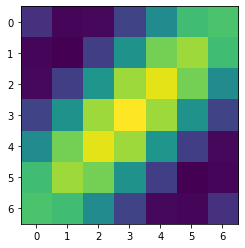

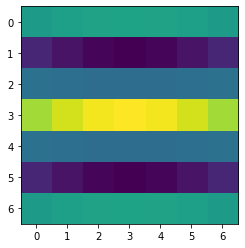

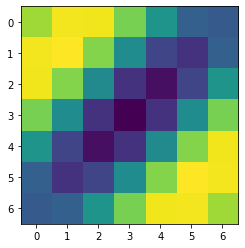

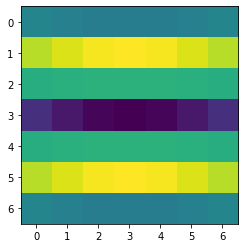

In [5]:
# sample filters
plt.imshow(filters[0])
plt.show()
plt.imshow(filters[2])
plt.show()
plt.imshow(filters[8])
plt.show()
plt.imshow(filters[10])
plt.show()

In [6]:
def get_weights():
    filters = generate_filter_bank()
    weights = torch.zeros((64,3,7,7))
    device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Set black and white gabor filters
    weights[:16,0,:,:] = torch.from_numpy(filters)
    weights[:16,1,:,:] = torch.from_numpy(filters)
    weights[:16,2,:,:] = torch.from_numpy(filters)

    # Set red and green gabor filters
    weights[16:32,0,:,:] = torch.from_numpy(filters)
    weights[16:32,1,:,:] = torch.from_numpy(filters)

    # Set red and blue gabor filters
    weights[32:48,0,:,:] = torch.from_numpy(filters)
    weights[32:48,2,:,:] = torch.from_numpy(filters)

    # Set green and blue gabor filters
    weights[48:,1,:,:] = torch.from_numpy(filters)
    weights[48:,2,:,:] = torch.from_numpy(filters)

    weights = weights.to(device)

    return weights

weights = get_weights()

## What do Gabor Filters respond to?

So now that we have all these custom filters, what do they actually respond to? Let's take a look.

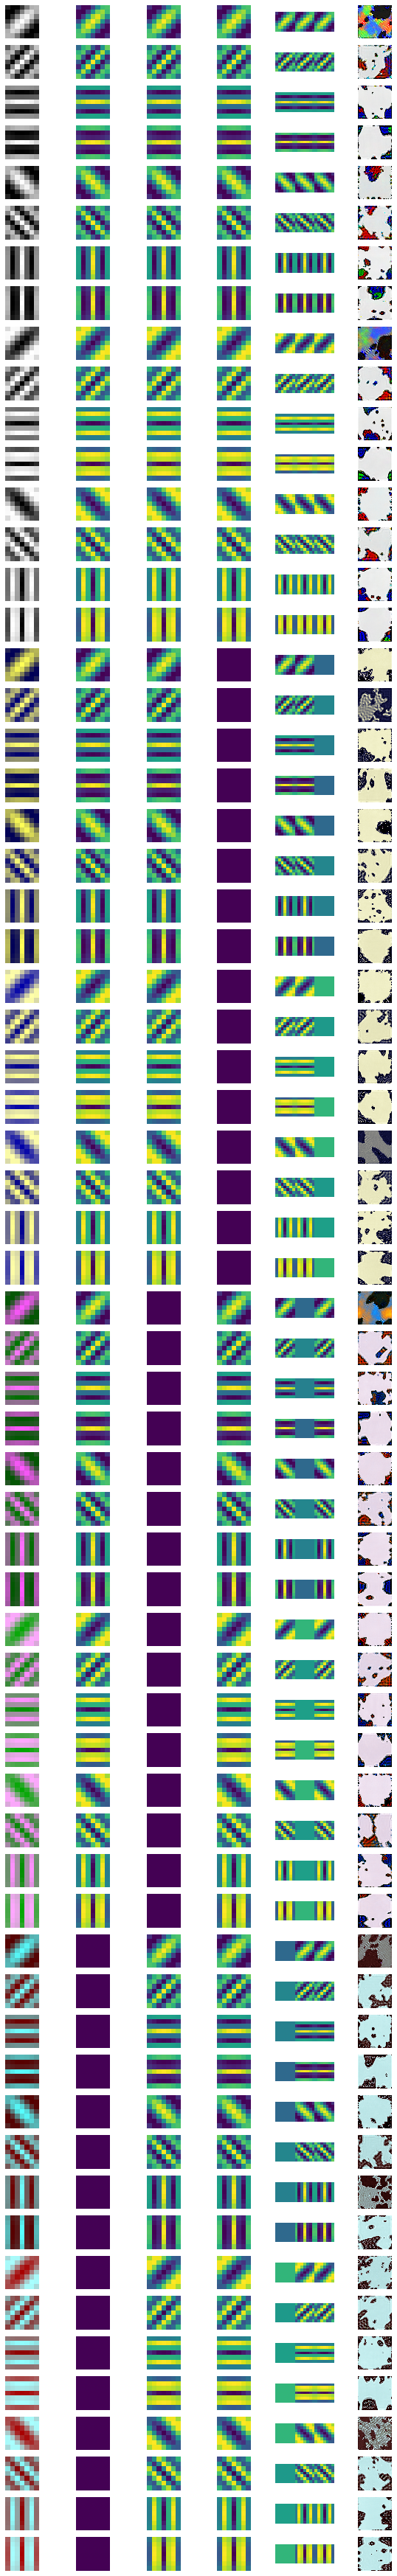

In [7]:
# Put filters into our resnet
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = get_weights()
model = resnet50(pretrained=False)
model.conv1.weight.data = weights
model = model.to(device)

rows = 64
cols = 6

fig = plt.figure(figsize=(10, 64))

for i in tqdm(range(1, rows + 1)):

    index = (i - 1) * cols
    
    filter = weights[i - 1]
    red = filter[0,:,:]
    green = filter[1,:,:]
    blue = filter[2,:,:]
    
    normalized = ((filter - filter.min())/(filter.max() - filter.min())).detach().cpu()
    normalized_red   = ((red - filter.min()) / (filter.max() - filter.min())).cpu()
    normalized_green = ((green - filter.min()) / (filter.max() - filter.min())).cpu()
    normalized_blue  = ((blue - filter.min()) / (filter.max() - filter.min())).cpu()
        
    # Individual plots
    fig.add_subplot(rows, cols, index + 1)
    plt.axis('off')
    plt.imshow(normalized.permute((1,2,0)))
    fig.add_subplot(rows, cols, index + 2)
    plt.axis('off')
    plt.imshow(normalized_red)
    fig.add_subplot(rows, cols, index + 3)
    plt.axis('off')
    plt.imshow(normalized_green)
    fig.add_subplot(rows, cols, index + 4)
    plt.axis('off')
    plt.imshow(normalized_blue)
    
    # Stacked plot to better show differences in magnitude between red, green and blue filters
    stacked_filters = np.hstack((normalized_red, normalized_green, normalized_blue))
    fig.add_subplot(rows, cols, index + 5)
    plt.axis('off')
    plt.imshow(stacked_filters)
    
    result = render.render_vis(model, "relu:" + str(i - 1), show_image=False, progress=False, thresholds=(256,))
    fig.add_subplot(rows, cols, index + 6)
    plt.axis('off')
    plt.imshow(result[0][0])
    
    
    

That's interesting, most of these don't seem to be edges like I would have guessed. We could probably tweak them until we act

## Compare Against Random Weights

So have we actually made anything useful? Let's compare a random network to one with our filters.

In [1]:
from fastai.vision import *

In [4]:
path = untar_data(URLs.CIFAR)

In [5]:
def trainLearner():
    data = ImageDataBunch.from_folder(path, valid='test', bs=128)
    learner = cnn_learner(data, models.resnet50, metrics=accuracy, pretrained=False)
    learner.unfreeze() # train whole network
    learner.fit_one_cycle(10, max_lr=1e-2)
    acc = learner.recorder.metrics[-1]
    return acc

In [6]:
acc1 = trainLearner()
acc2 = trainLearner()
acc3 = trainLearner()

print("Avg accuracy:", np.mean((acc1, acc2, acc3)))

epoch,train_loss,valid_loss,accuracy,time
0,1.848920,1.994516,0.382300,00:21
1,2.121100,2.509887,0.184500,00:20
2,2.016731,2.442988,0.308400,00:21
3,1.720806,1.709474,0.416000,00:21
4,1.406722,2.932277,0.314700,00:21
5,1.180207,5.989246,0.566800,00:22
6,0.998968,1.053909,0.640000,00:22
7,0.830501,18.856705,0.685400,00:22
8,0.677314,3.812740,0.710700,00:22
9,0.586527,4.809606,0.714300,00:22


epoch,train_loss,valid_loss,accuracy,time
0,1.827144,1.759791,0.372500,00:22
1,1.932910,4.332092,0.355200,00:22
2,1.862046,1.870286,0.367100,00:23
3,1.880274,2.735202,0.342800,00:22
4,1.447865,1.837602,0.492400,00:22
5,1.291582,2.537445,0.542400,00:22
6,1.127729,1.118069,0.601900,00:22
7,0.954893,3.830166,0.658200,00:22
8,0.806522,0.945411,0.683000,00:21
9,0.715081,1.141922,0.695900,00:22


epoch,train_loss,valid_loss,accuracy,time
0,1.843423,2.088539,0.346100,00:23
1,2.155705,3.405488,0.165900,00:22
2,2.325151,11.469940,0.201000,00:22
3,1.943591,1.907026,0.260500,00:23
4,1.622769,1.539947,0.426200,00:22
5,1.363247,2.263697,0.527100,00:21
6,1.192837,43.337162,0.535200,00:22
7,1.042123,12.897882,0.589400,00:22
8,0.896126,35.271912,0.660400,00:22
9,0.832859,24.970451,0.665400,00:21


Avg accuracy: 0.6918667


In [42]:
def trainLearnerWithFilters():
    data = ImageDataBunch.from_folder(path, valid='test', bs=128)
    learner = cnn_learner(data, models.resnet50, metrics=accuracy, pretrained=False)
    
    learner.model[0][0].weight.data = weights
    
    learner.unfreeze() # train whole network
    learner.fit_one_cycle(10, max_lr=1e-2)
    acc = learner.recorder.metrics[-1]
    return acc

In [43]:
acc1 = trainLearnerWithFilters()
acc2 = trainLearnerWithFilters()
acc3 = trainLearnerWithFilters()

print("Avg accuracy:", np.mean((acc1, acc2, acc3)))

epoch,train_loss,valid_loss,accuracy,time
0,1.787995,1.729151,0.415800,00:20
1,1.651469,1.626416,0.446400,00:21
2,1.753577,2.210950,0.423500,00:23
3,1.371171,371.908112,0.210800,00:24
4,1.126446,1.173526,0.591800,00:22
5,0.973133,11.565470,0.604200,00:22
6,0.804810,17.518581,0.685000,00:22
7,0.666872,5.192451,0.732100,00:23
8,0.509420,1.224431,0.749900,00:22
9,0.423351,1.613644,0.752100,00:22


epoch,train_loss,valid_loss,accuracy,time
0,1.650917,1.573119,0.472700,00:22
1,1.671772,2.002503,0.415000,00:21
2,1.772808,1.572370,0.427000,00:23
3,1.185721,1.313986,0.615700,00:23
4,0.989425,1.280266,0.590600,00:23
5,0.833081,1.069583,0.646800,00:23
6,0.661754,3.456589,0.753900,00:22
7,0.494939,11.677612,0.760500,00:23
8,0.346352,1.289413,0.783500,00:23
9,0.261362,3.361222,0.786400,00:23


epoch,train_loss,valid_loss,accuracy,time
0,1.510552,1.422872,0.493600,00:23
1,1.734703,127.264626,0.119700,00:22
2,1.400461,2.145432,0.344500,00:23
3,1.081707,1.784705,0.519800,00:23
4,0.922590,31.087309,0.670700,00:22
5,0.771420,0.922434,0.715800,00:22
6,0.622976,0.876273,0.735900,00:22
7,0.449869,0.907081,0.765700,00:23
8,0.315553,1.768057,0.784300,00:23
9,0.233275,19.451540,0.783200,00:23


Avg accuracy: 0.77390003


So that's kind of cool: We can get much better results (for 10 epochs at least) if we start training with our custom weights. There are probably things we could improve with our weights so this is encouraging.

## How much do our weights change during training?

I'm curious whether our weights have been changed beyond recognition by gradient descent. Can we still identify each weight or are they completely different than how we initialized them?

In [47]:
data = ImageDataBunch.from_folder(path, valid='test', bs=128)
learner = cnn_learner(data, models.resnet50, metrics=accuracy, pretrained=False)

learner.model[0][0].weight.data = weights

learner.unfreeze() # train whole network
learner.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.498895,1.315753,0.522600,00:21
1,1.524856,1.702952,0.443600,00:22
2,1.334929,3.583409,0.307400,00:21
3,1.212187,1.582669,0.519500,00:22
4,1.000770,1.263588,0.583700,00:22
5,0.852616,1.059306,0.633600,00:21
6,0.695545,4.708318,0.725000,00:22
7,0.524250,4.807485,0.769200,00:22
8,0.364371,92.117035,0.780000,00:21
9,0.250852,53.664326,0.784100,00:21


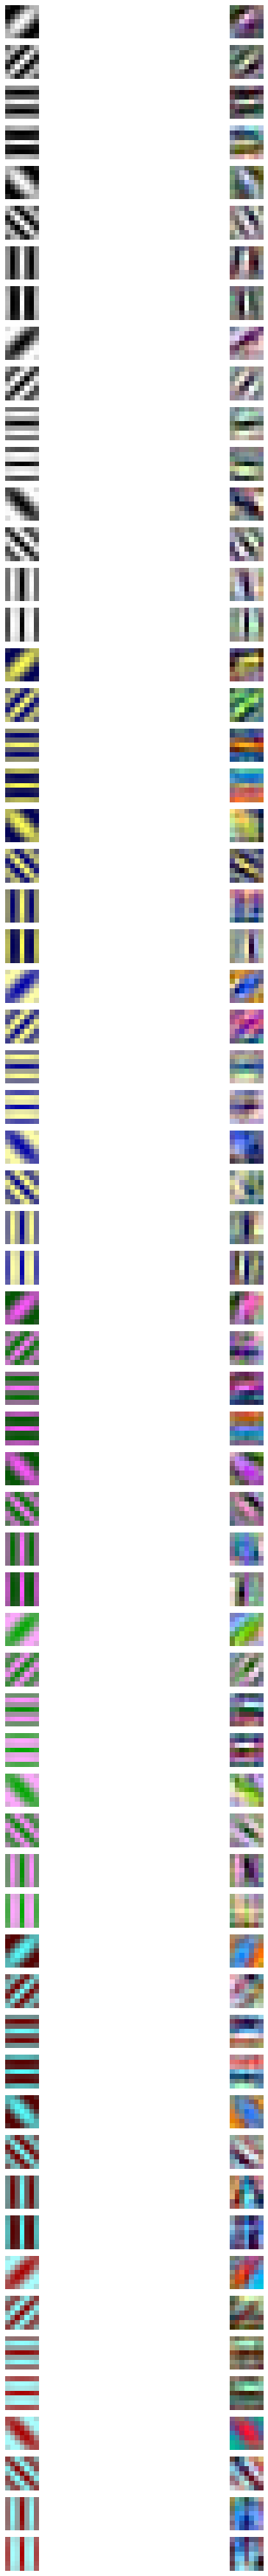

In [68]:
# Now we plot the before/after weights
weights = get_weights()

rows = 64
cols = 2

fig = plt.figure(figsize=(10, 64))

for i in range(1, rows + 1):
    index = (i - 1) * cols
    
    original_filter = weights[i - 1].cpu().detach()
    original_filter = (original_filter - original_filter.min())/(original_filter.max() - original_filter.min())
    
    new_filter = learner.model[0][0].weight[i - 1].cpu().detach()
    new_filter = (new_filter - new_filter.min())/(new_filter.max() - new_filter.min())
    
    fig.add_subplot(rows, cols, index + 1)
    plt.axis('off')
    plt.imshow(original_filter.permute((1,2,0)))
    
    fig.add_subplot(rows, cols, index + 2)
    plt.axis('off')
    plt.imshow(new_filter.permute((1,2,0)))

So there are certainly some differences, but many of the patterns appear to remain roughly the same.

The most obvious changes are the color changes. In particular I've noticed a lot of these neural networks really like to have blue and orange filters. Our original Gabor filters didn't really meet this need so the network made the filters itself.